## Generate single cell heatmaps

In [1]:
suppressPackageStartupMessages(library(ComplexHeatmap))
suppressPackageStartupMessages(library(dplyr))

In [2]:
# Set paths and constants
set.seed(1234)
sample_cell_frac = 0.1

plate_to_focus <- "localhost220513100001_KK22-05-198_FactinAdjusted"

# input_data_dir <- file.path("..", "..", "..", "3.process-cfret-features", "data")
input_data_dir <- file.path("..", "UMAP", "temp")
file_suffix <- "_sc_norm_fs_cellprofiler.csv.gz_dropna.csv.gz"
cp_file <- file.path(
    input_data_dir, paste0(plate_to_focus, file_suffix)
)

output_figure_dir <- "figures"
cp_heatmap_file_noext <- file.path(output_figure_dir, "cp_complex_heatmap")

In [3]:
# Load data
cp_df <- readr::read_csv(
    cp_file,
    col_types = readr::cols(
        .default="d",
        "Metadata_WellRow" = "c",
        "Metadata_WellCol" = "c",
        "Metadata_heart_number" = "c",
        "Metadata_treatment" = "c",
        "Metadata_dose" = "c",
        "Metadata_ImageNumber" = "c",
        "Metadata_Plate" = "c",
        "Metadata_Well" = "c"
    )
) %>%  # Add dose numeric column
    dplyr::mutate(
        Metadata_dose_value = as.numeric(stringr::str_remove(Metadata_dose, "uM"))
    )

# Add cell count column
cell_count_df <- cp_df %>%
    dplyr::group_by(Metadata_Well) %>%
    dplyr::count()

cp_df <- cp_df %>%
    dplyr::left_join(cell_count_df, by = "Metadata_Well") %>%
    dplyr::rename(Metadata_cell_count_per_well = n)

print(dim(cp_df))
head(cp_df, 3)

[1] 17352   599


Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_treatment,Metadata_dose,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,⋯,Nuclei_Texture_SumEntropy_ER_3_03_256,Nuclei_Texture_SumEntropy_Golgi_3_01_256,Nuclei_Texture_SumEntropy_Mitochondria_3_03_256,Nuclei_Texture_SumVariance_Actin_3_01_256,Nuclei_Texture_SumVariance_ER_3_03_256,Nuclei_Texture_SumVariance_Golgi_3_01_256,Nuclei_Texture_SumVariance_Hoechst_3_01_256,Nuclei_Texture_SumVariance_Mitochondria_3_03_256,Metadata_dose_value,Metadata_cell_count_per_well
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
A,9,9,drug_x,5uM,1,localhost220513100001,A09,1,3,⋯,0.3830138,1.5279864,1.6033489,-0.4200762,-0.2362416,0.20380578,-0.3547300,0.16163561,5,342
A,9,9,drug_x,5uM,1,localhost220513100001,A09,2,4,⋯,-0.9223457,-0.4915354,-1.0004204,-0.4608149,-0.4684389,-0.20632511,-0.3310333,-0.18902928,5,342
A,9,9,drug_x,5uM,1,localhost220513100001,A09,3,7,⋯,0.1231898,0.9340863,0.9589492,-0.4689575,-0.2375866,-0.03696811,-0.1078189,-0.06320025,5,342


## Create a heatmap for CP features

In [4]:
# Setup heatmap colors
treatment_colors = c(
    "drug_x" = "#785EF0",
    "DMSO" = "#DC267F"
)

# From colorbrewer2.org
spectral_palette <- c(
    "#fff7ec",
    "#fee8c8",
    "#fdd49e",
    "#fdbb84",
    "#fc8d59",
    "#ef6548",
    "#d7301f",
    "#b30000",
    "#7f0000"
)

spectral_limits <- c(0, max(cp_df$Metadata_dose_value))

spectral_breaks <- seq(
    spectral_limits[1],
    spectral_limits[2],
    length.out = length(spectral_palette)
) 

dose_col <- circlize::colorRamp2(spectral_breaks, spectral_palette)

In [5]:
# Randomly sample cells
# Split metadata and feature data
cp_feature_df <- cp_df %>%
    dplyr::sample_frac(sample_cell_frac)

cp_metadata_df <- cp_feature_df %>%
    dplyr::select(tidyr::starts_with("Metadata"))
cp_meta_cols <- colnames(cp_metadata_df)

cp_feature_df <- cp_feature_df %>% dplyr::select(-!!cp_meta_cols)

In [6]:
# Calculate correlation matrix from feature data
cp_cor_matrix <- t(cp_feature_df) %>% cor()

print(dim(cp_cor_matrix))
head(cp_cor_matrix, 3)

[1] 1735 1735


1.0000000,-0.1578061,0.2987375,-0.37067137,-0.1160086,0.38355178,-0.1341096,-0.2617274,-0.1417035,0.1435279,⋯,-0.3825370,0.5654094,0.05965804,-0.038867541,0.4608011,0.1495371,-0.10423242,0.1852772,0.4936591,-0.13222059
-0.1578061,1.0000000,-0.1601040,0.07474996,0.3029487,-0.39568093,0.2216561,0.3373990,-0.1092807,-0.2440731,⋯,0.3441713,-0.1499260,-0.02809097,0.048013647,-0.3545460,-0.2749792,-0.05839629,-0.3230787,-0.3587822,-0.09574272
0.2987375,-0.1601040,1.0000000,-0.21916039,-0.1282652,0.09619491,-0.2274621,-0.3268625,-0.1987781,0.1004610,⋯,-0.2029779,0.3128570,-0.16612297,0.005459212,0.1693550,0.1329546,0.03159755,0.2267122,0.1486098,0.01544891


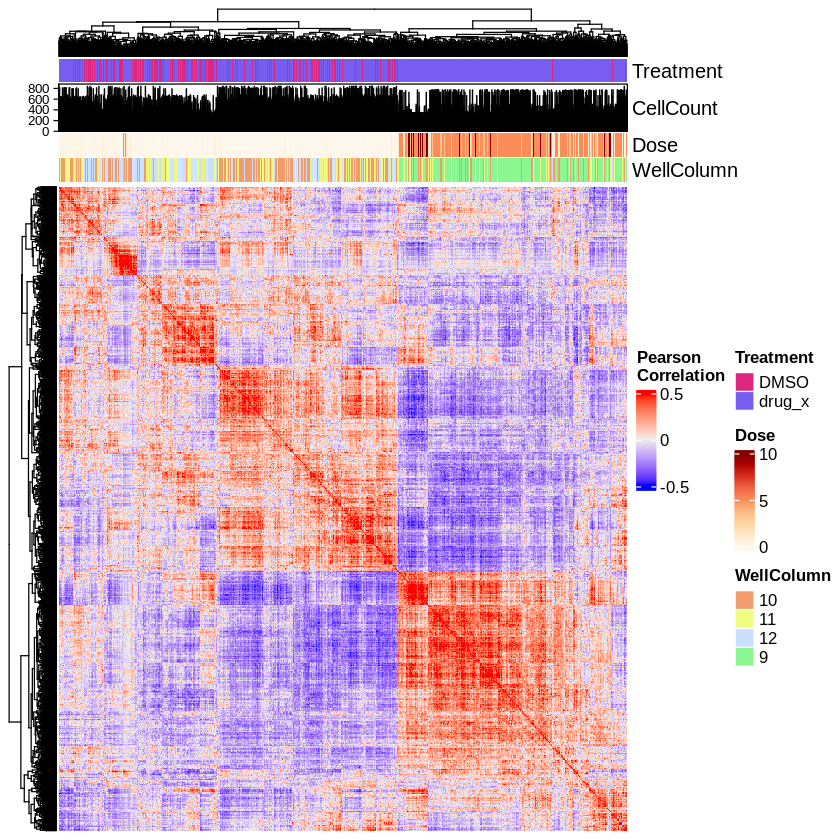

In [7]:
# Generate heatmap
ht <- Heatmap(
    cp_cor_matrix,
    name = "Pearson\nCorrelation",
    column_dend_side = "top",
    
    clustering_method_columns = "average",
    clustering_method_rows = "average",
    
    top_annotation = HeatmapAnnotation(
        Treatment = cp_metadata_df$Metadata_treatment,
        CellCount = anno_barplot(
            cp_metadata_df$Metadata_cell_count_per_well,
            height = unit(1, "cm")
        ),
        Dose = cp_metadata_df$Metadata_dose_value,
        WellColumn = cp_metadata_df$Metadata_WellCol,
        
        col = list(
            Treatment = treatment_colors,
            Dose = dose_col
        )

    )
)

draw(ht)

In [8]:
# Save heatmap to file
pdf(paste0(cp_heatmap_file_noext, ".pdf"))
draw(ht)
dev.off()

png(paste0(cp_heatmap_file_noext, ".png"), width = 6.5, height = 6, units = "in", res = 500)
draw(ht)
dev.off()

png 
  2

png 
  2